In [1]:
import xarray as xr
import numpy as np
from os.path import join
import matplotlib.pyplot as plt
import matplotlib as mpl
import cmocean
from glob import glob
import pandas as pd
from copy import deepcopy
import gsw
import gen_utils
import seaborn as sns
sns.set()

to-do
- use higher resolution data...?
    - i.e. do same analysis, but without interpolating first....
- How to pick thermocline?
    - plot stratification as a function of distance, by iso-line...?
    - plot error as a function of iso-line choice
    - plot vertical gradient of potential density (super-impose on $\theta$ or $\rho$ contours)
    - try a bunch of different thermoclines

In [2]:
def velocity_xr(u_vals, v_vals):
    '''Put velocity values in xarray dataarray'''
    # Put on correct grid    
    velocity = xr.DataArray(np.stack([u_vals,v_vals],axis=0), 
                            coords={'name':['u','v'], 'p'   :uv['DepthCenterCell'].values,
                                    'dist':uv['DistanceCenterCell'].values/1000, # convert to km
                                    'time':data.time[::-1]}, dims=['name','time','p','dist'])
    velocity['p'] = -gsw.z_from_p(velocity['p'], lat=40.3) # convert pressure to depth
    velocity      = velocity.rename({'p':'depth'})
    velocity      = velocity.reindex(time=velocity.time[::-1]) # time dimension matches density data
    velocity      = velocity.interp({'dist':data.dist}) # interpolate distances to match density data
    return velocity

def get_ym(data, idx):
    '''Get year and month from the data, given data and index'''
    time = data.time.isel(time=idx)
    y    = time.dt.year.values.item()
    m    = time.dt.month.values.item()
    return y, m

def get_lower_upper(data, iso):
    '''Get quantity averaged over lower and upper layers of the 1.5 layer model'''
    lower_list, upper_list = [], []
    for d in data.dist:
        boundary  = iso.sel(dist=d).values.item() 
        lower = data.sel(dist=d, depth=slice(boundary,None))
        upper = data.sel(dist=d, depth=slice(None,boundary))
        lower, upper = [x.mean('depth').values.item() for x in [lower, upper]]
        lower_list.append(lower)
        upper_list.append(upper)
    return np.array(lower_list), np.array(upper_list)

def get_iso_np(data, x):
    '''Given a dataset and the value of an isopycnal/therm, get coordinates of isopycnal/therm'''
    levels = np.array([x])
    idx = np.where(levels==x)[0].item()
    p = plt.contour(data['dist'], data['depth'], data.T, levels=levels)
    plt.close()
    c = p.allsegs[idx][np.argmax([len(y) for y in p.allsegs[idx]])]
    return c

def get_iso_xr(iso):
    '''Convert isoline to xarray'''
    iso = xr.DataArray(iso[:,1], coords={'dist':pd.Index(iso[:,0])}, dims=['dist'])
    iso = iso.drop_duplicates('dist').interp(dist=data['dist'])
    return iso

def get_iso(data,x):
    '''Combines get_iso_xr and get_iso_np'''
    return get_iso_xr(get_iso_np(data,x))

def get_xgrad(iso):
    '''Compute horizontal gradient of the isoline'''
    return iso.differentiate('dist') / 1000 # convert from km to m

def get_gprime(rho, iso):
    '''Compute reduced gravity, based on isotherm/isopycnal'''
    g = 9.8
    rho_lower, rho_upper = get_lower_upper(rho, iso)
    gprime = deepcopy(iso)
    gprime.values = g * (rho_lower-rho_upper) / (rho_upper + 1000) #
    return gprime

def est_velocity(rho, iso):
    '''Get estimated velocity from data, based on selected iso-line'''
    # Compute coriolis parameter
    omega  = 2*np.pi/(3600*24) # rotation rate of earth (radians/sec)
    f      = 2*omega*np.sin(np.deg2rad(40.3)) # estimate of f0, based on latitude of ~40 degrees N
    
    # Compute horizontal gradient and reduced gravity
    grad   = get_xgrad(iso)
    gprime = get_gprime(rho, iso) # Compute reduced gravity
    v      = gprime / f * grad    # velocity
    return v

# Load data

## Density

In [3]:
# data  = xr.open_dataset('ctd-data.nc')
data  = xr.open_dataset('ctd-data_no-interp.nc')
data['p'] = -gsw.z_from_p(data['p'], lat=40.3)
data = data.rename({'p':'depth'})

## Velocity
For transformed coordinate system, use projection array computed in ```lab2_load-data.ipynb```

In [4]:
## ADCP velocities
uv = xr.open_dataset('VelocityData.nc')

###### Transformed velocity ######
# Projection matrix
P = np.array([[ 0.44254196, -0.8967478 ],
              [ 0.8967478 ,  0.44254196]])
uv = xr.open_dataset('VelocityData.nc')
u  = uv['AllUArray'].values
v  = uv['AllVArray'].values

# Get transformed velocities
uv_stack = np.stack([u,v],axis=0)
uvhat      = (P @ uv_stack.reshape(2,-1)).reshape(uv_stack.shape)
vhat_adcp = velocity_xr(uvhat[0], uvhat[1])

###### Speed ###########
v_     = np.sqrt(uv['AllUArray']**2 + uv['AllVArray']**2).values
u_     = 0 * deepcopy(v)
speed_adcp = velocity_xr(u_,v_)

# Compute theoretical velocity

Compute geostrophic velocity based on "reduced gravity'' equations:  
$fv = g\nabla \eta_1$  
$\implies v = \frac{g}{f}\frac{\partial\eta_1}{\partial x}$

In [7]:
mpl.rcParams['figure.dpi'] = 200

time_idx      = 1
iso_level     = 12 # 12 degrees C, or 27 kg/m^3 seems to give reasonable results...
name          = 'T' # one of {'T','rho'}
name_plot     = 'T' # which variable to contour on the plots...
plot_velocity = False
take_mean     = False

## take mean if desired
if take_mean:
    data, vhat_adcp, speed_adcp  = [x.mean('time', keepdims=True) for x in [data, vhat_adcp, speed_adcp]]
    
## Compute isoline and velocity
data_ = data.isel(time=time_idx)          # get correct timestep
rho_  = data['rho'].isel(time=time_idx)   # density
iso   = get_iso(data_[name], x=iso_level) # compute depth of isoline
iso2  = get_iso(data_['T'], x=12) # compute depth of isoline
vhat  = est_velocity(rho_, iso)           # estimate velocity

# Partition ADCP data by layer
vhat_adcp_lo, vhat_adcp_hi = get_lower_upper(vhat_adcp.sel(name='v').isel(time=time_idx), iso)
s_adcp_lo, s_adcp_hi       = get_lower_upper(speed_adcp.sel(name='v').isel(time=time_idx), iso)

### Integrated transport 
'''Note: taking the mean is not good enough!!!! e.g. if velocity varies non-lienarly with depth'''
vhat_transport      = vhat          * iso # integrated transport (note: units of iso are 'm')
vhat_adcp_transport = vhat_adcp_hi  * iso
s_adcp_tranport     = s_adcp_hi     * iso

# Plot cross-section and estimated speed
Velocity colors, isothermal/pycnals contoured, with selected isopycnal highlighted

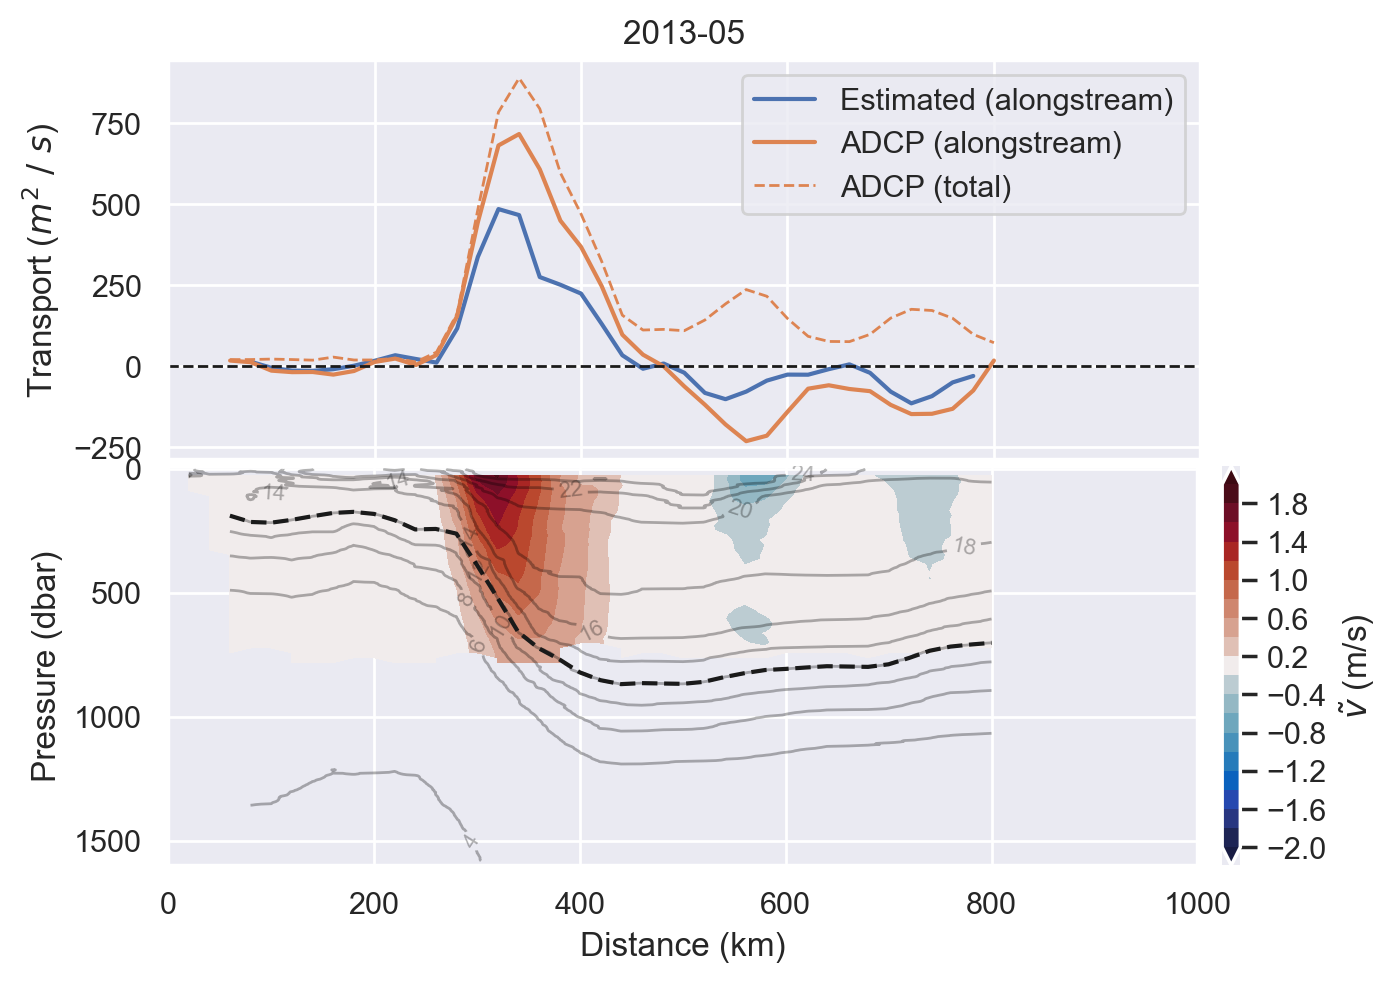

In [9]:
##### Plotting 
c = sns.color_palette()
figsize = np.array([8,16/3])
fig = plt.figure(figsize=figsize)
gs = fig.add_gridspec(20,30)

#### Land vs. Ocean #####
ax0 = fig.add_subplot(gs[:10,:25])
if plot_velocity:
    p1 = ax0.plot(vhat.dist, vhat.values,  label='Estimated (alongstream)')
    p2 = ax0.plot(vhat.dist, vhat_adcp_hi, color=c[1], label='ADCP (alongstream)')
    p2 = ax0.plot(vhat.dist, s_adcp_hi,    color=c[1], label='ADCP (total)', ls='--', lw=1)
    ax0.set_ylabel('Velocity ($m~/~s$)')
else:
    p1 = ax0.plot(vhat.dist, vhat_transport.values,          label='Estimated (alongstream)')
    p2 = ax0.plot(vhat.dist, vhat_adcp_transport,  color=c[1], label='ADCP (alongstream)')
    p2 = ax0.plot(vhat.dist, s_adcp_tranport,      color=c[1], label='ADCP (total)', ls='--', lw=1)
    ax0.set_ylabel(r'Transport ($m^2~/~s$)')
ax0.set_xticklabels([])
ax0.axhline(0,ls='--',lw=1,c='k')
ax0.set_xlim([0,1000])
ax0.legend()
y,m = get_ym(data, time_idx) if not take_mean else (None,None)
ax0.set_title(f'{y}-{m:02d}' if not take_mean else 'Mean')

#### Plot Velocity profile ####
ax = fig.add_subplot(gs[10:,:])
p = ax.contourf(vhat_adcp.dist, vhat_adcp.depth, vhat_adcp.sel(name='v').isel(time=time_idx), 
                cmap='cmo.balance', levels=gen_utils.make_cb_range(2,.2), extend='both')
cb = fig.colorbar(p, orientation='vertical', label=r'$\tilde{v}$ (m/s)', pad=.02)

# Iso-lines (temperature or density)
data_plot = data.isel(time=time_idx)[name_plot].T
levels    = np.arange(0,25,2) if name_plot=='T' else np.arange(25,28.2,.05)
p = ax.contour(data.dist, data.depth, data_plot, colors='black', linewidths=1,
               levels=levels, extend='both', alpha=.3) # create contour plot
ax.clabel(p, fontsize=8)

ax.plot(iso.dist, iso.values, c='k', ls='--')
# ax.plot(iso2.dist, iso2.values, c=c[2], ls='--')
ax.set_ylabel('Pressure (dbar)')
ax.set_xlabel('Distance (km)')
ax.set_ylim([-10,1600])
plt.gca().invert_yaxis() # reverse order of y axis so that depth decreases going down

plt.show()

# Iso-line selection
Plot vertical gradient

Compute the vertical gradient as a function of isoline

Note probably want to take a window around the given isoline (to capture the extent of stratification...).  

I.e. we want to find the "middle" of the thermocline, but it may be uniformly stratified.

In [89]:
def get_mean_zgrad(data, iso, delta):
    '''Get mean vertical gradient given dataarray and iso-line. Delta is the window to avg over.'''
    valid_idx  = np.where(~np.isnan(iso.values))[0] # get non-NaN slices (required for argmin)
    valid_dist = iso.dist.isel(dist=valid_idx)
    iso_       = iso.sel(dist=valid_dist)
    zgrad      = data.sel(dist=valid_dist).differentiate('depth')
    L = np.abs(zgrad.depth.values - iso_.values[:,None]) # compute distances
    min_idx = np.nanargmin(L, axis=1) 

    # Loop through distances to compute vertical gradient at each location
    zgrads = []
    for d,i in zip(zgrad.dist, min_idx):
        zgrads.append(zgrad.sel(dist=d).isel(depth=slice(i-delta, i+delta)).mean('depth').values.item())
        
    return zgrads

(0.0, -0.04)

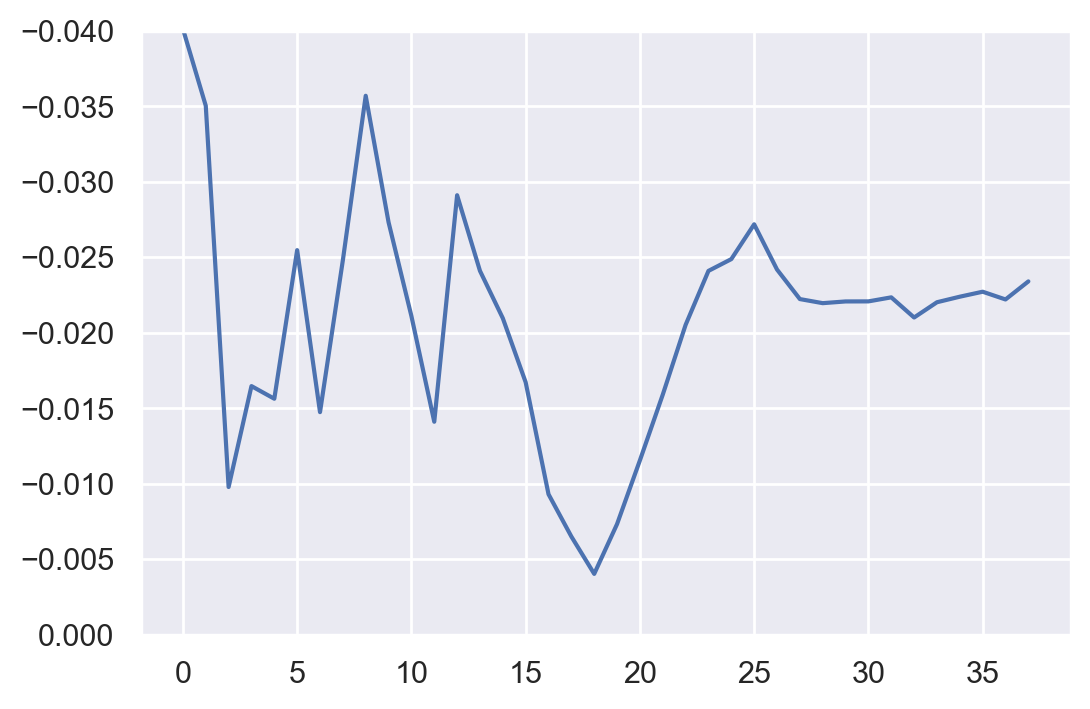

In [91]:
plt.plot(get_mean_zgrad(data.isel(time=0)['T'], iso = iso, delta=20))
plt.ylim([0,-.04])

In [92]:
name = 'T'

for iso_level in [np.arange(4,23)]:
    
    iso = get_iso(data_[name], x=iso_level) # compute depth of isoline

    valid_idx  = np.where(~np.isnan(iso.values))[0]
    valid_dist = iso.dist.isel(dist=valid_idx)
    iso_      = iso.sel(dist=valid_dist)
    zgrad     = data.isel(time=time_idx).sel(dist=valid_dist).differentiate('depth')[name]
    L = np.abs(zgrad.depth.values - iso_.values[:,None]) # compute distances
    min_idx = np.nanargmin(L, axis=1) 

    # Loop through distances to compute vertical gradient at each location
    zgrads = []
    delta = 20 # sliding window to use (i.e. vertical gradient averaged over double this width; must be integer)
    for d,i in zip(zgrad.dist, min_idx):
        zgrads.append(zgrad.sel(dist=d).isel(depth=slice(i-delta, i+delta)).mean('depth').values.item())

ValueError: can only convert an array of size 1 to a Python scalar

(0.0, -0.04)

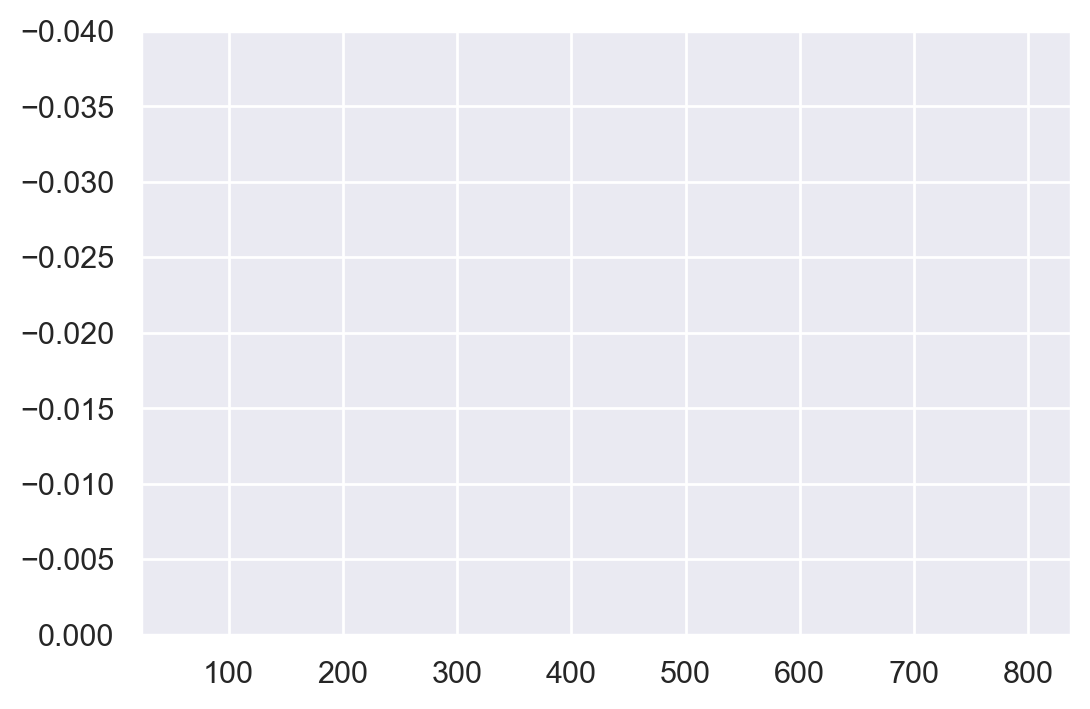

In [93]:
plt.plot(valid_dist, zgrads)
plt.ylim([0,-.04])

First try: plot vertical gradient everywhere

In [83]:
help(ax.errorbar)

Help on method errorbar in module matplotlib.axes._axes:

errorbar(x, y, yerr=None, xerr=None, fmt='', ecolor=None, elinewidth=None, capsize=None, barsabove=False, lolims=False, uplims=False, xlolims=False, xuplims=False, errorevery=1, capthick=None, *, data=None, **kwargs) method of matplotlib.axes._subplots.AxesSubplot instance
    Plot y versus x as lines and/or markers with attached errorbars.
    
    *x*, *y* define the data locations, *xerr*, *yerr* define the errorbar
    sizes. By default, this draws the data markers/lines as well the
    errorbars. Use fmt='none' to draw errorbars without any data markers.
    
    Parameters
    ----------
    x, y : float or array-like
        The data positions.
    
    xerr, yerr : float or array-like, shape(N,) or shape(2, N), optional
        The errorbar sizes:
    
        - scalar: Symmetric +/- values for all data points.
        - shape(N,): Symmetric +/-values for each data point.
        - shape(2, N): Separate - and + values fo

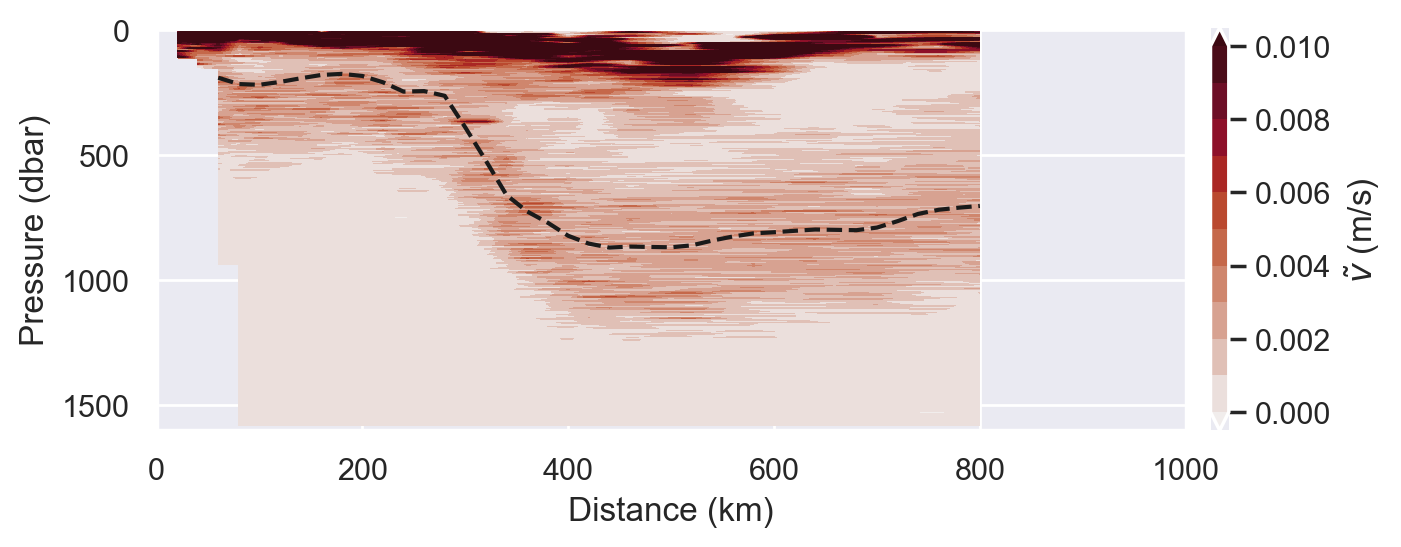

In [82]:
time_idx=1
name = 'rho'
zgrad = data.differentiate('depth')[name]

##### Plotting 
c = sns.color_palette()
figsize = np.array([8,16/6])
fig = plt.figure(figsize=figsize)
gs = fig.add_gridspec(10,30)
#### Plot Velocity profile ####
ax = fig.add_subplot(gs[:,:])
if name=='T':
    p = ax.contourf(zgrad.dist, zgrad.depth, -zgrad.isel(time=time_idx).T, cmap='cmo.amp', extend='both',
                    levels=np.arange(0,.11,.01))
else:
    p = ax.contourf(zgrad.dist, zgrad.depth, zgrad.isel(time=time_idx).T, cmap='cmo.amp', extend='both',
                    levels=np.arange(0,.011,.001))
cb = fig.colorbar(p, orientation='vertical', label=r'$\tilde{v}$ (m/s)', pad=.02)

# Iso-lines (temperature or density)
data_plot = data.isel(time=time_idx)[name_plot].T
levels    = np.arange(0,25,2) if name_plot=='T' else 12

ax.plot(iso.dist, iso.values, c='k', ls='--')
ax.error
ax.set_ylabel('Pressure (dbar)')
ax.set_xlabel('Distance (km)')
ax.set_ylim([-10,1600])
plt.gca().invert_yaxis() # reverse order of y axis so that depth decreases going down

plt.show()